# PREVISIBILIDADE EM FORECASTING DE SÉRIES TEMPORAIS

As séries temporais variam drasticamente em sua previsibilidade inerente, desde padrões altamente previsíveis, com ciclos sazonais claros e tendências estáveis até processos quase aleatórios. 

Compreender essas limitações e aprender a quantificar a previsibilidade e reconhecer quando a previsão provavelmente terá sucesso ou fracassará é essencial, pois dessa forma, podemos evitar esforços desperdiçados, modelos inadequados e previsões enganosas.

O fato é: Modelos avançados, sobretudo em cenários complexos, só podem ter sucesso quando os dados subjacentes exibem padrões temporais, regularidade de sinais ou memória. Quando as séries temporais são dominadas por ruído ou contêm pouca dinâmica explorável, mesmo os métodos mais sofisticados falham.

Chamamos de Previsibilidade a propriedade da própria série temporal que captura o limite teórico de quão bem os valores futuros podem ser previstos, dada a informação disponível. Se uma série temporal for completamente aleatória, nenhuma modelagem inteligente irá melhorar sua previsão. Se ela mantiver estrutura, sinal ou memória, então a porta para a previsibilidade se abre.

Compreender a previsibilidade ajuda a responder a perguntas críticas.

1. Vale a pena modelar esta série?
2. Devemos dedicar tempo à engenharia de recursos ou apenas usar uma linha de base ingênua?
3. Qual é a melhor precisão que podemos esperar alcançar?
4. Podemos definir expectativas com as partes interessadas antes de queimar ciclos na modelagem?

Pesquisas confirmam que há sim uma forte relação empírica entre medidas intrínsecas de previsibilidade (como entropia e autocorrelação) e a precisão das previsões alcançadas em conjuntos de dados simulados e do mundo real. Ou seja, investir tempo na avaliação de previsibilidade antecipadamente vale a pena para tomar decisões mais inteligentes sobre a estratégia de modelagem de maneira antecipada.

Veremos um pipeline de como fazer isso abaixo:

In [67]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from hurst import compute_Hc
import antropy as ant
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm

In [56]:
# Carregar DFs

# Dataset previsível: AirPassengers
data_air = get_rdataset("AirPassengers").data
df_air = pd.DataFrame({
    "date": pd.date_range(start="1949-01-01", periods=len(data_air), freq="ME"),
    "value": data_air["value"].values
})

# Dataset imprevisível: Bitcoin
df_btc = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01")[["Close"]].reset_index()
df_btc.rename(columns={"Date": "date", "Close": "value"}, inplace=True)

df_btc["value"] = df_btc["value"].astype(float)
df_btc["value"] = df_btc["value"].values.reshape(-1)

# Garantir que não há NaNs e o vetor é suficientemente longo
x_air = df_air["value"].dropna().values
x_btc = df_btc["value"].dropna().values

/var/folders/f_/phx6fdtn19vctznq8l4wdk4r0000gn/T/ipykernel_59543/3627766221.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_btc = yf.download("BTC-USD", start="2020-01-01", end="2025-01-01")[["Close"]].reset_index()
[*********************100%***********************]  1 of 1 completed


Abaixo temos duas Séries temporais, uma delas sendo a famosa série AirPassengers e a outra sendo o valor do Bitcoin ao longo do tempo.

Repare que para o primeiro, apenas olhando para o gráfico temos algo bem claro: essa série tem bastante tendência e sazonalidade, isso indica alta previsibilidade logo de cara. O número de passageiros tem uma **têndencia** clara em aumentar ao longo dos anos enquanto os picos no gráfico se repetem quase que a cada ano, indicando bastante **sazonalidade** também. Ou seja, em termos estatísticos, há uma **componente de tendência positiva** que é estável e explicável (cresce a cada ano), além de uma **estrutura periódica bem definida** que se repete com intensidade crescente na série.

Já para o gráfico do Bitcoin, temos uma série que aparenta ser mais ****volátil, ruidosa e instável**, com picos em várias épocas diferentes e quedas abruptas. Além disso, não parece existir **nenhum tipo de periodicidade regular** nessa série. Ela é estacionária e bastante ruidosa, com **baixa autocorrelação e alta entropia de permutação. (pouca estrutura repetitiva)**. Logo, é uma série de baixa previsibilidade intrínseca.

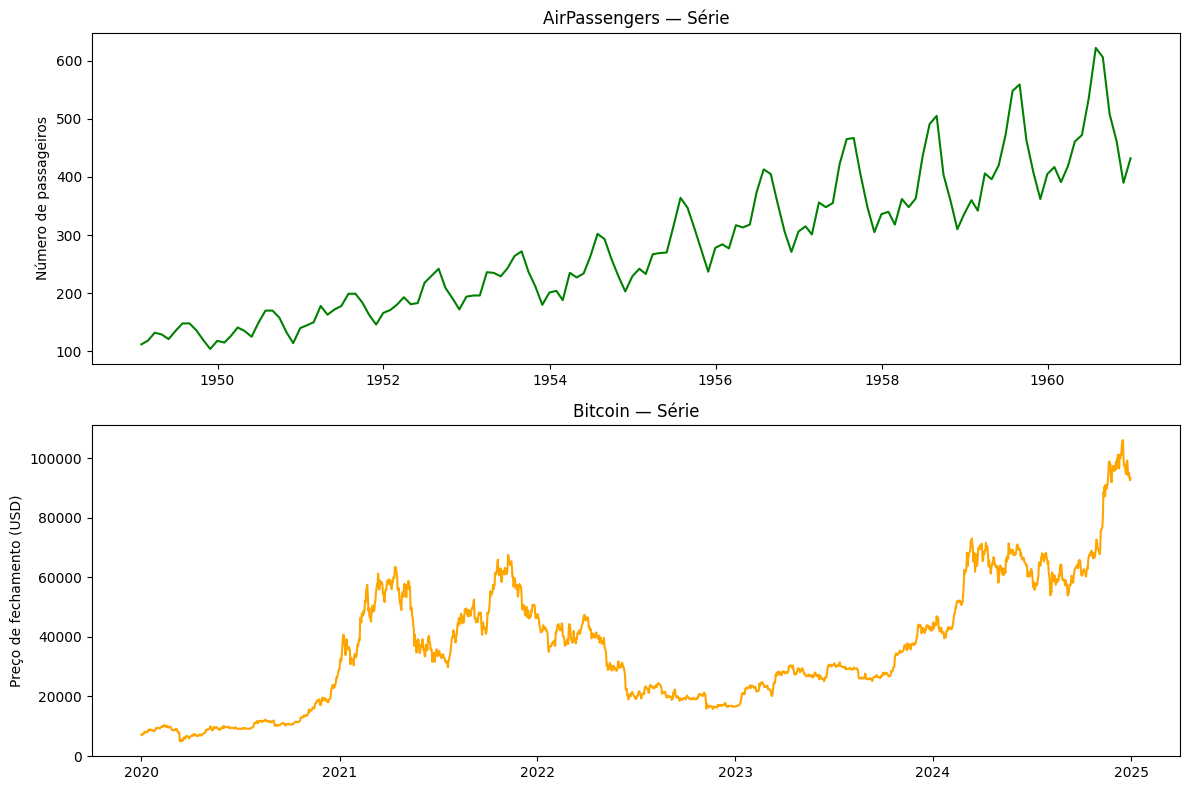

In [57]:
# Plots das séries temporais
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
axes[0].plot(df_air["date"], df_air["value"], color="green")
axes[0].set_title("AirPassengers — Série")
axes[0].set_ylabel("Número de passageiros")

axes[1].plot(df_btc["date"], df_btc["value"], color="orange")
axes[1].set_title("Bitcoin — Série")
axes[1].set_ylabel("Preço de fechamento (USD)")
plt.tight_layout()
plt.show()

Agora, vamos calcular a ACF/PACF das séries além do Hurst para tentar quantificar a previsibilidade intrínseca dessa série:

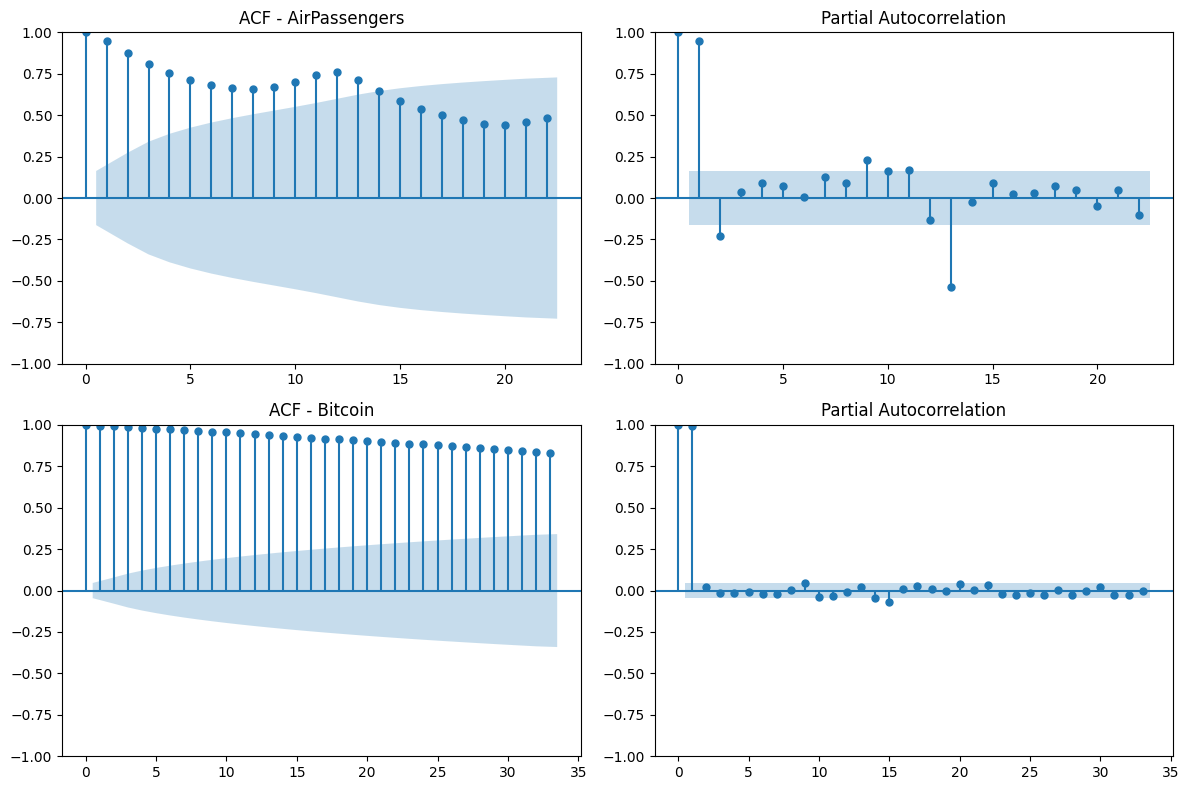

Hurst AirPassengers: 0.518
Hurst Bitcoin: 0.554


In [58]:
# Autocorrelação
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_air["value"], ax=ax[0,0])
plot_pacf(df_air["value"], ax=ax[0,1])
plot_acf(df_btc["value"], ax=ax[1,0])
plot_pacf(df_btc["value"], ax=ax[1,1])
ax[0,0].set_title("ACF - AirPassengers")
ax[1,0].set_title("ACF - Bitcoin")
plt.tight_layout()
plt.show()

# Hurst exponent
H_air, _, _ = compute_Hc(df_air["value"], simplified=True)
H_btc, _, _ = compute_Hc(df_btc["value"], simplified=True)
print(f"Hurst AirPassengers: {H_air:.3f}")
print(f"Hurst Bitcoin: {H_btc:.3f}")

Opa, calculamos essas métricas sem remover a tendência e sazonalidades de nossa séries, e isso é um **pecado** para a nossa modelagem. Essas métricas pressupõem estacionariedade na série, e se calcularmos esses valores sem remover esses artefatos, viciamos essas métricas que passam a descrever mais a estrutura determinística da série ao invés da dependência estocástica real. Logo, é essencial removermos esses artefatos para modelarmos.

Por que dá errado sem remover T e S:
1. ACF / PACF
- Tendência faz a ACF ficar alta em quase todos os lags (ex.: Bitcoin com ACF colada em ~1), porque valores grandes vêm depois de valores grandes → autocorrelação espúria.
- Sazonalidade injeta picos periódicos (lags 12, 24, …) que parecem “memória”, mas são só repetição do calendário.
Resultado: a leitura “pré-modelagem” parece alta previsibilidade, mas é artefato de T e S.

2. Exponente de Hurst (H)
- H mede memória de longo prazo assumindo série (quase) estacionária.
- Tendência e random walk elevam H artificialmente (puxam para >0.5).
Mesmo seu H de 0.518 (AirPassengers) e 0.554 (BTC) já indica esse viés: parece “persistência”, mas vem da não-estacionariedade (nível mudando), não de uma dinâmica previsível dos resíduos.

3. Entropia de Permutação (PE)
- PE mede a desordem dos padrões locais de ordem (não a sazonalidade global).
- Séries multiplicativas (AirPassengers) têm amplitudes que mudam dentro do ciclo; localmente a ordem dos pontos varia muito → PE sobe (0.913) mesmo havendo padrão anual fortíssimo.
- Ou seja: a sazonalidade global não baixa a PE, porque ela olha janelas curtas e é sensível a microvariações e a ruído sobre um nível crescente.

Então, vamos resolver isso:

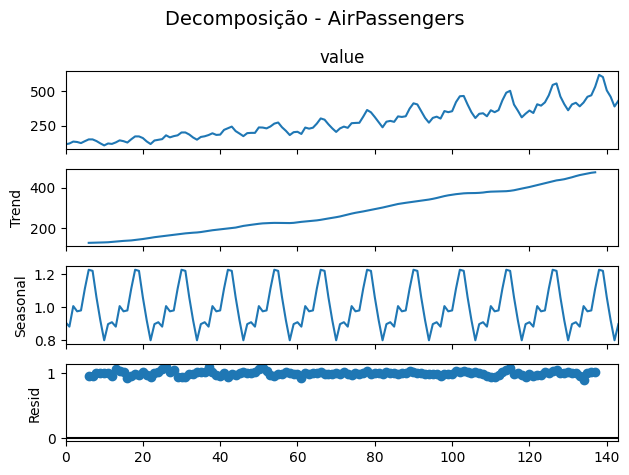

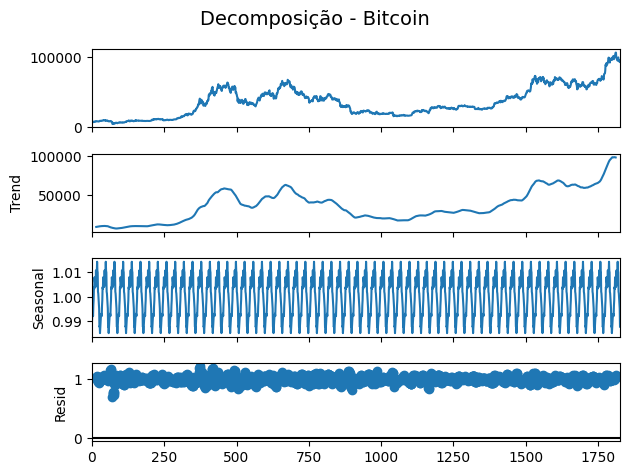

In [59]:
# 1. Decomposição das séries
# AirPassengers → sazonalidade anual
result_air = seasonal_decompose(df_air["value"], model="multiplicative", period=12)
res_air = result_air.resid.dropna()

# Bitcoin → sazonalidade mensal aproximada
result_btc = seasonal_decompose(df_btc["value"], model="multiplicative", period=30)
res_btc = result_btc.resid.dropna()

# 2. Visualização da decomposição
def plot_decomposition(result, title):
    result.plot()
    plt.suptitle(f"Decomposição - {title}", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_decomposition(result_air, "AirPassengers")
plot_decomposition(result_btc, "Bitcoin")

Uma série temporal pode ser entendida como um sinal composto de **tendência + sazonalidade + ruído**.  
Uma estratégia interessante é **decompor esse sinal** nessas três componentes, para então trabalhar com as **séries residuais**, ou seja, o que sobra após retirarmos as estruturas determinísticas.  

O gráfico acima demonstra a **decomposição das nossas séries** — AirPassengers e Bitcoin — e evidencia a diferença entre uma **série determinística** e uma **série estocástica**.

### AirPassengers — Série Determinística

#### 1. Componente *Trend* (Tendência)

A linha de tendência é **suave, crescente e bem definida**.  
Ela mostra um **crescimento consistente** do número de passageiros ao longo do tempo — o que reflete um fenômeno real e estruturado (a expansão da aviação comercial entre 1949 e 1961).

**Conclusão:** existe uma **tendência determinística** — previsível e modelável por funções simples (linear, exponencial, etc.).

#### 2. Componente *Seasonal* (Sazonalidade)

Os ciclos são **periódicos e regulares**, com uma frequência de **12 meses**.  
A amplitude da sazonalidade cresce junto com o nível da série → comportamento **multiplicativo**.

- **Exemplo:** os picos se repetem nos mesmos meses todos os anos (verão), e as baixas também (inverno).  
- **Conclusão:** há **sazonalidade estável** → a cada ano, o padrão se repete quase idêntico.

#### 3. Componente *Resid* (Resíduos)

O ruído é **pequeno**, **distribuído aleatoriamente** e **sem padrão aparente**.  
Isso mostra que **a maior parte da variação é explicada** por tendência + sazonalidade.

#### **Resumo AirPassengers**

- Série **altamente estruturada**, com **padrões fixos e previsíveis**.  
- A decomposição **capturou quase tudo**, restando apenas **ruído branco** (comportamento puramente aleatório).

---

### Bitcoin — Série Estocástica

#### 1. Componente *Trend*

A tendência é **irregular, instável e não monotônica**:

- Períodos de **forte alta** (*bull runs*);  
- Seguidos de **quedas bruscas** (*crashes*).

Isso mostra que o “trend” muda de direção várias vezes, não sendo uma estrutura determinística estável — e sim **reflexo de choques externos** (mercado, notícias, políticas monetárias, etc.).

**Conclusão:** tendência **não estacionária** e **não determinística**.

#### 2. Componente *Seasonal*

A parte “sazonal” identificada pela decomposição mostra **microvariações de curtíssimo prazo**, mas sem padrão real.  
O que parece sazonalidade é apenas **ruído periódico falso** — flutuações diárias que o algoritmo tenta ajustar.

**Conclusão:**  
Não há **sazonalidade genuína**, apenas **ruído de alta frequência** confundido como padrão.

#### 3. Componente *Resid*

Os resíduos ainda apresentam **alta amplitude** e **heterocedasticidade** (volatilidade variável).  
Isso significa que:

- Mesmo após a decomposição, **há muita estrutura não explicada**;  
- Os resíduos **não se comportam como ruído branco** — há dependência condicional da variância.

**Conclusão:**  
A decomposição **não conseguiu isolar uma estrutura previsível**.  
A maior parte do comportamento do Bitcoin é **aleatório, não sazonal e não linear**.

### **Interpretação:**  
O *AirPassengers* é o exemplo clássico de **previsibilidade determinística**, enquanto o *Bitcoin* é dominado por **choques estocásticos** e **volatilidade imprevisível**.  
A decomposição torna essa diferença visualmente evidente.

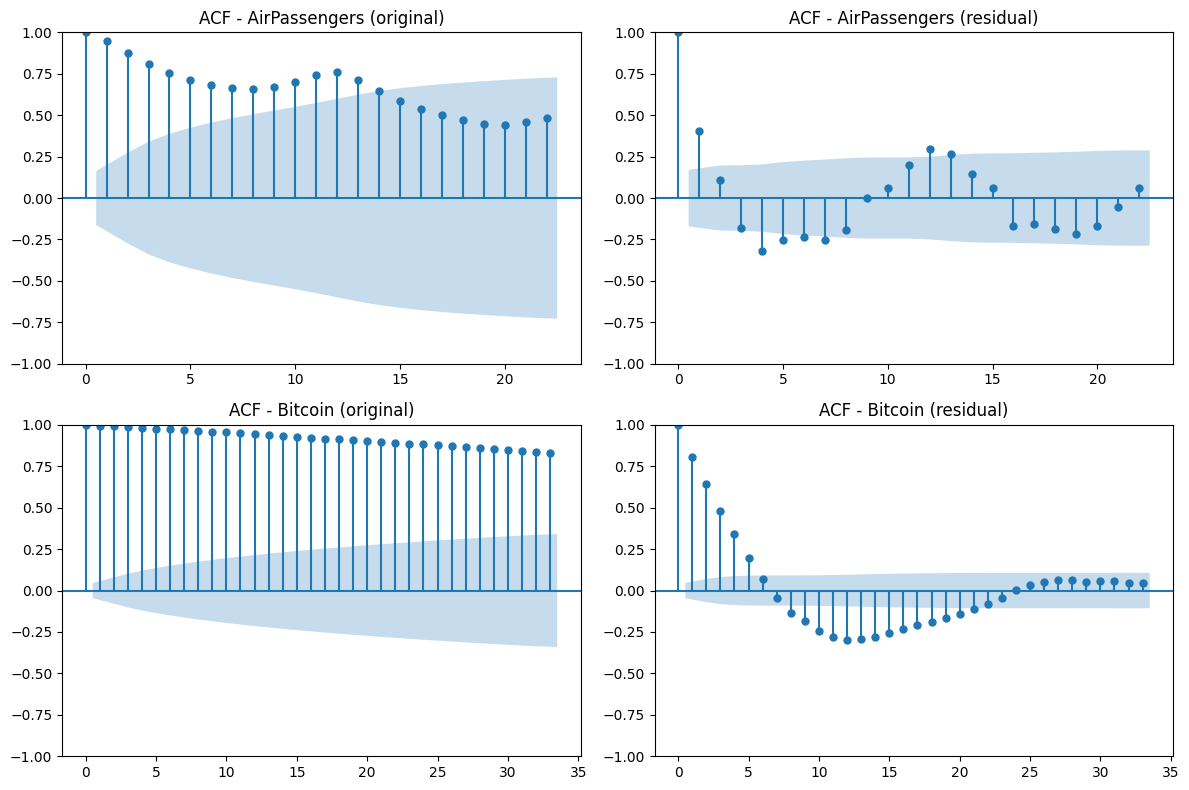

In [60]:
# 3. Comparação ACF e PACF (antes vs depois)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(df_air["value"], ax=axes[0, 0])
plot_acf(res_air, ax=axes[0, 1])
axes[0, 0].set_title("ACF - AirPassengers (original)")
axes[0, 1].set_title("ACF - AirPassengers (residual)")

plot_acf(df_btc["value"], ax=axes[1, 0])
plot_acf(res_btc, ax=axes[1, 1])
axes[1, 0].set_title("ACF - Bitcoin (original)")
axes[1, 1].set_title("ACF - Bitcoin (residual)")

plt.tight_layout()
plt.show()

Agora, plotamos novamente a ACF, só que dessa vez, plotando as dias séries (sem decomposição e apenas a parte residual). A ACF mede o quanto uma série está correlacionada com suas versões defasadas no tempo (lags). Valores altos de autocorrelação indicam **padrões temporais previsíveis**, enquanto valores baixos (ou próximos de zero) indicam **aleatoriedade**.

O que podemos extrair é que:
### AirPassengers — Série Determinística

#### ACF Original
- Correlações **altas e decaindo lentamente** ao longo dos lags.  
- Indica uma **forte tendência positiva** — valores elevados tendem a ser seguidos de valores ainda maiores.  
- Picos periódicos em múltiplos de 12 revelam **sazonalidade anual** bem definida.

**Interpretação:**  
A série é **altamente dependente do tempo**, com padrão previsível de longo prazo e repetição sazonal.

#### ACF Residual
- Após remover tendência e sazonalidade, a autocorrelação **cai rapidamente**.  
- Apenas o lag 1 apresenta correlação moderada (~0.3–0.4), e todos os demais lags estão **dentro da faixa azul** (intervalo de confiança).  
- Isso indica ausência de estrutura temporal significativa nos resíduos.

**Interpretação:**  
A decomposição capturou **quase toda a previsibilidade determinística** da série.  
Os resíduos se comportam como **ruído branco**, ou seja, variação puramente aleatória sem memória temporal.

---

### Bitcoin — Série Estocástica

#### ACF Original
- Correlações **muito altas** em todos os lags (próximas de 1).  
- Isso sugere persistência, mas é um **efeito espúrio** causado pela **tendência não estacionária**: longos períodos de preços altos seguidos de longos períodos de quedas.  
- A série mantém memória artificial por causa da escala e da não linearidade.

**Interpretação:**  
Aparentemente previsível, mas essa autocorrelação é apenas reflexo da **não estacionariedade** da série.  
Os altos níveis de preço “arrastam” a correlação para cima.

#### ACF Residual
- A autocorrelação decai mais rapidamente, mas ainda há **padrões oscilatórios**: correlações positivas nos primeiros lags e negativas em torno de lag 10–20.  
- Esse comportamento é típico de séries com **volatilidade agrupada** (efeito GARCH) e **dependência condicional**.

**Interpretação:**  
Mesmo após a decomposição, o Bitcoin mantém **estrutura temporal nos resíduos**.  
Os erros ainda contêm informação previsível, refletindo a natureza **estocástica e volátil** do mercado.

---

### Conclusão

- **AirPassengers:**  
  A decomposição removeu praticamente toda a previsibilidade — restando apenas ruído.  
  A série é **determinística e estacionarizável**, com padrão fixo e modelável.

- **Bitcoin:**  
  Mesmo após decompor, há **autocorrelação e volatilidade nos resíduos**.  
  A série é **não determinística**, influenciada por fatores externos e choques de mercado.  
  Modelos adequados precisam capturar **heterocedasticidade** e **não linearidades** (GARCH, LSTM, Prophet com regressões, etc.).

**Síntese final:**  
> A decomposição separou o *previsível* (tendência e sazonalidade) do *aleatório*.  
> No *AirPassengers*, o previsível explica quase tudo;  
> No *Bitcoin*, o aleatório ainda domina — a previsibilidade aparente da ACF original era apenas um artefato da não estacionariedade.

,Série,Hurst,Entropia
0,AirPassengers (original),0.518430,0.913027
1,AirPassengers (residual),0.235644,0.988719
2,Bitcoin (original),0.554473,0.977574
3,Bitcoin (residual),0.269710,0.976353


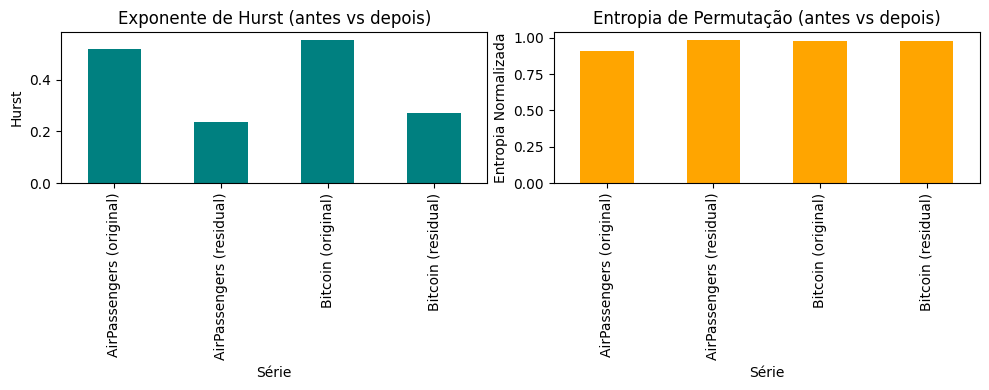

In [61]:
# 4. Métricas de previsibilidade
def calc_metrics(series, name):
    series = pd.Series(np.array(series).flatten()).dropna().values  # sempre 1D
    H, _, _ = compute_Hc(series, simplified=True)
    pe = ant.perm_entropy(series, normalize=True)
    return {"Série": name, "Hurst": H, "Entropia": pe}

metrics = []
metrics.append(calc_metrics(df_air["value"], "AirPassengers (original)"))
metrics.append(calc_metrics(res_air, "AirPassengers (residual)"))
metrics.append(calc_metrics(df_btc["value"], "Bitcoin (original)"))
metrics.append(calc_metrics(res_btc, "Bitcoin (residual)"))

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

# 5. Comparação visual das métricas
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

metrics_df.plot(x="Série", y="Hurst", kind="bar", ax=ax[0], color="teal", legend=False)
ax[0].set_title("Exponente de Hurst (antes vs depois)")
ax[0].set_ylabel("Hurst")

metrics_df.plot(x="Série", y="Entropia", kind="bar", ax=ax[1], color="orange", legend=False)
ax[1].set_title("Entropia de Permutação (antes vs depois)")
ax[1].set_ylabel("Entropia Normalizada")

plt.tight_layout()
plt.show()

#### Métricas de Previsibilidade — Exponente de Hurst e Entropia de Permutação

As métricas abaixo quantificam **duas dimensões complementares da previsibilidade** de uma série temporal:

1. **O grau de dependência temporal** (Hurst);  
2. **O grau de desordem ou aleatoriedade** (Entropia de Permutação).

O gráfico compara esses valores **antes e depois da decomposição** (ou seja, série original vs. resíduos).

### Exponente de Hurst

O **exponente de Hurst (H)** mede a *persistência temporal* de uma série — isto é, o quanto o comportamento passado influencia o futuro.  

| Intervalo de H | Interpretação | Tipo de Comportamento |
|-----------------|----------------|------------------------|
| **H < 0.5** | Anti-persistente — alterna frequentemente (ruído branco) | Ruído, reversão à média |
| **H ≈ 0.5** | Aleatório (random walk) | Processo puramente estocástico |
| **H > 0.5** | Persistente — mantém a direção de variação | Tendência determinística |

#### AirPassengers
- **Original:** H = **0.52** → ligeiramente persistente → há **dependência temporal** (tendência + sazonalidade).  
- **Residual:** H = **0.23** → torna-se **anti-persistente**, indicando **ruído branco** sem estrutura temporal.

**Interpretação:**  
A decomposição removeu completamente a memória da série.  
O que restou não é previsível — ótimo sinal de que a tendência e sazonalidade foram bem isoladas.

#### Bitcoin
- **Original:** H = **0.55** → ligeira persistência, mas causada por **não estacionariedade** (preços crescentes por longos períodos).  
- **Residual:** H = **0.27** → queda significativa, indicando menor dependência temporal, porém **ainda não puramente aleatório**.

**Interpretação:**  
A decomposição reduziu parte da estrutura previsível, mas ainda resta **correlação temporal e volatilidade**.  
O Bitcoin continua com ruído correlacionado — típico de séries financeiras.

---

### Entropia de Permutação

A **Entropia de Permutação (PE)** mede o *grau de aleatoriedade* na sequência de padrões locais da série.  
Ela é **normalizada entre 0 e 1**, onde:

| Valor de Entropia | Interpretação |
|--------------------|----------------|
| **Próximo de 0** | Série altamente ordenada (determinística) |
| **Próximo de 1** | Série caótica ou aleatória (sem estrutura previsível) |

#### AirPassengers
- **Original:** 0.91 → há **estrutura temporal forte**, mas com certo ruído.  
- **Residual:** 0.99 → **quase aleatório**, o modelo retirou toda a ordem determinística.

**Interpretação:**  
A entropia aumentou, indicando que a **informação previsível foi completamente removida**.  
A série residual é dominada por ruído branco.

#### Bitcoin
- **Original:** 0.97 → já muito próxima do aleatório, confirmando sua natureza **estocástica**.  
- **Residual:** 0.98 → quase sem mudança; a decomposição **não conseguiu reduzir a desordem**, pois a série já era essencialmente caótica.

**Interpretação:**  
A entropia se manteve alta — a dinâmica do Bitcoin é **intrinsecamente ruidosa e imprevisível**.

---

### Comparativo Geral

| Série | Hurst (antes) | Hurst (depois) | Entropia (antes) | Entropia (depois) | Interpretação |
|-------|----------------|----------------|------------------|-------------------|----------------|
| **AirPassengers** | 0.52 | 0.23 | 0.91 | 0.99 | Série determinística: previsível → ruído branco |
| **Bitcoin** | 0.55 | 0.27 | 0.98 | 0.98 | Série estocástica: ruído e volatilidade persistem |

### Conclusão

- **AirPassengers:**  
  Após remover tendência e sazonalidade, a série tornou-se **ruído puro**, sem memória nem estrutura.  
  Isso indica **alta previsibilidade determinística** (o modelo explica praticamente tudo).

- **Bitcoin:**  
  Mesmo após decomposição, as métricas confirmam sua **baixa previsibilidade**.  
  A série é **estocástica, volátil e dominada por ruído** — previsões puramente determinísticas são ineficazes.

**Síntese final:**  
> O *AirPassengers* é um sistema **ordenado e previsível**, onde o modelo capta toda a informação temporal.  
> O *Bitcoin* é um sistema **caótico e ruidoso**, cuja complexidade não é explicável apenas por tendência ou sazonalidade.


Mas se as métricas de previsibilidade mostradas acima indicam valores parecidos(ambas têm Hurst < 0.5, sugerindo comportamento anti-persistente (ou ruído), ambas têm Entropia ≈ 1, indicando alta desordem. ), como foi possível perceber qual série tinha alta previsibilidade determinística e qual não? 

Essas métricas são globais e resumem o comportamento médio da série.

Duas séries completamente diferentes (um ruído branco puro e um ruído heterocedástico, por exemplo) podem ter valores similares de Hurst e Entropia, mas estruturas internas totalmente distintas.

Vamos voltar aos gráficos da ACF aplicada nos resíduos. 
- Analisando a ACF dos resíduos podemos sacar algumas coisas:
  - Cai rapidamente para zero e oscila dentro do intervalo azul, → indica ruído branco (sem estrutura temporal).
  - Mantém padrões ou oscilações sistemáticas, → indica ruído estruturado (ainda há memória).

Então,
#### AirPassengers
- A ACF residual mostra **rápida queda para zero**, com todos os lags dentro do intervalo de confiança.  
- Não há padrão periódico nem correlação significativa.

**Interpretação:**  
Os resíduos são **independentes e identicamente distribuídos (i.i.d.)**, caracterizando **ruído branco puro**.  
Toda a estrutura determinística foi capturada pela decomposição — o modelo explicou quase toda a variação observada.

#### Bitcoin
- A ACF residual apresenta **padrão oscilatório** e **correlações significativas em vários lags**.  
- Há alternância de correlações positivas e negativas, indicando **memória curta e dependência residual**.  
- Esse comportamento é típico de **séries financeiras** com *volatilidade agrupada* (efeito GARCH).

**Interpretação:**  
Os resíduos ainda contêm **estrutura temporal** — não são completamente aleatórios.  
Mesmo após a remoção da tendência e de flutuações periódicas, permanece **dependência condicional na variância** (heterocedasticidade).

---

### Comparativo dos Resíduos

| Indicador | AirPassengers (residual) | Bitcoin (residual) | Interpretação |
|------------|---------------------------|--------------------|----------------|
| **Hurst ↓** | 0.23 | 0.27 | Ambas perderam persistência |
| **Entropia ↑** | 0.99 | 0.98 | Ambas ficaram quase aleatórias |
| **ACF** | Sem correlação significativa | Padrão oscilatório persistente | Bitcoin mantém estrutura temporal |
| **Distribuição dos resíduos** | Simétrica e homogênea | Assimétrica e heterocedástica | Bitcoin apresenta volatilidade variável |

---

### Conclusão

- **AirPassengers:**  
  A decomposição removeu completamente a dependência temporal.  
  Os resíduos se comportam como **ruído branco puro**, indicando que a série é **altamente previsível e determinística**.

- **Bitcoin:**  
  Mesmo com Hurst e Entropia sugerindo alta aleatoriedade, a **ACF evidencia memória residual e dependência de volatilidade**.  
  A série é **estocástica e não linear**, com ruído estruturado.

**Síntese final:**  
> As métricas globais (Hurst, Entropia) medem o grau médio de previsibilidade,  
> mas apenas a **ACF revela se o ruído remanescente ainda possui estrutura temporal**.  
>  
> No *AirPassengers*, restou ruído branco.  
> No *Bitcoin*, restou ruído estruturado — caótico, porém não completamente aleató


HW(ETS)  MAE=12.38  MAPE=2.81%


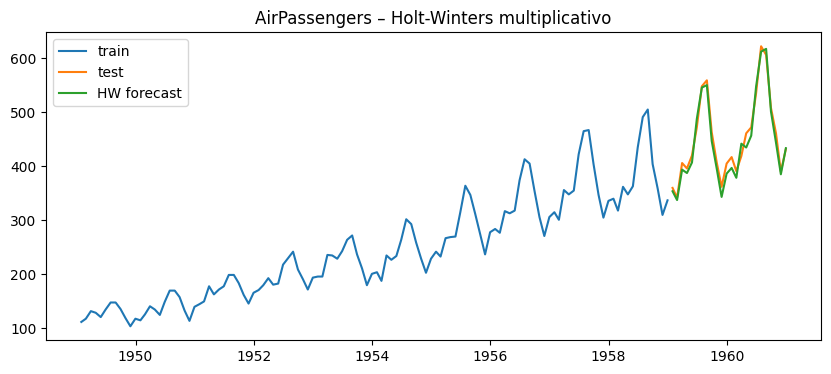

In [ ]:
# df_air: colunas ["date","value"] (mensal)
ts = df_air.set_index("date")["value"].asfreq("ME")

# split: últimos 24 meses para teste
train, test = ts.iloc[:-24], ts.iloc[-24:]

# Holt-Winters multiplicativo (ETS: Error-Trend-Seasonal)
hw = ExponentialSmoothing(
    train,
    trend="mul",            # tendência multiplicativa
    seasonal="mul",         # sazonalidade multiplicativa
    seasonal_periods=12
).fit(optimized=True, use_brute=True)

pred = hw.forecast(len(test))

# métricas
mae  = mean_absolute_error(test, pred)
mape = mean_absolute_percentage_error(test, pred)

print(f"HW(ETS)  MAE={mae:.2f}  MAPE={100*mape:.2f}%")

# gráfico
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="train")
plt.plot(test.index, test, label="test")
plt.plot(pred.index, pred, label="HW forecast")
plt.legend(); plt.title("AirPassengers – Holt-Winters multiplicativo"); plt.show()

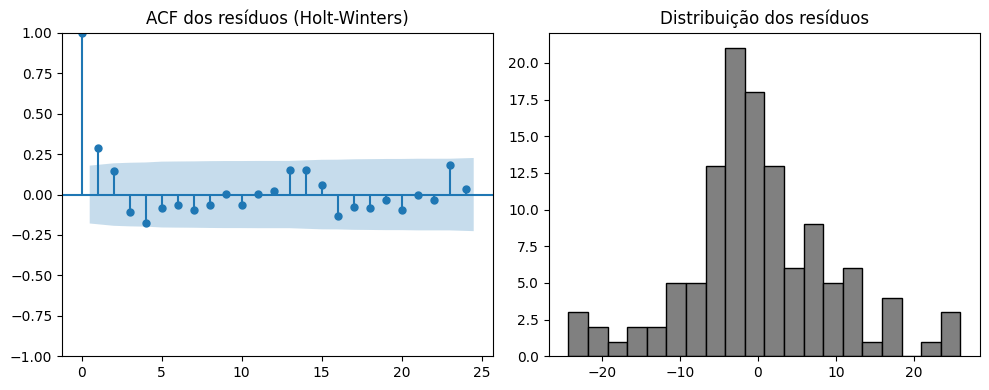

Exponente de Hurst: 0.185
Entropia de Permutação: 0.981
Desvio Padrão dos resíduos: 9.529


In [66]:
resid = hw.resid.dropna()

# Plot ACF e histograma
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sm.graphics.tsa.plot_acf(resid, lags=24, ax=ax[0])
ax[0].set_title("ACF dos resíduos (Holt-Winters)")
ax[1].hist(resid, bins=20, color='gray', edgecolor='black')
ax[1].set_title("Distribuição dos resíduos")
plt.tight_layout()
plt.show()

# Métricas estatísticas
H, _, _ = compute_Hc(resid, simplified=True)
pe = ant.perm_entropy(resid, normalize=True)

print(f"Exponente de Hurst: {H:.3f}")
print(f"Entropia de Permutação: {pe:.3f}")
print(f"Desvio Padrão dos resíduos: {resid.std():.3f}")

Por fim, fizemos a modelagem da série **AirPassengers** utilizando o método de **Holt-Winters multiplicativo (ETS)**, que permite capturar simultaneamente tendência e sazonalidade de natureza proporcional ao nível da série. O modelo apresentou excelente desempenho preditivo, com erro médio percentual (MAPE) de apenas **2,8%**, indicando que a maior parte da estrutura determinística foi explicada. A análise dos resíduos mostrou um comportamento característico de **ruído branco puro**: a **ACF** não apresentou autocorrelações significativas, demonstrando ausência de dependência temporal; o **histograma** dos resíduos revelou uma distribuição aproximadamente normal e centrada em zero, sem viés sistemático; e as métricas estatísticas reforçaram essa conclusão — o **exponente de Hurst** foi de **0.185** (anti-persistente), a **entropia de permutação** atingiu **0.981** (altamente aleatória) e o **desvio padrão** dos resíduos foi relativamente baixo (**9.53**). Esses resultados confirmam que o modelo capturou completamente a tendência e a sazonalidade da série, restando apenas ruído não estruturado, o que caracteriza um ajuste quase perfeito e uma excelente modelagem da componente previsível do processo.


HW(ETS) Bitcoin  MAE=31367.62  MAPE=59.15%


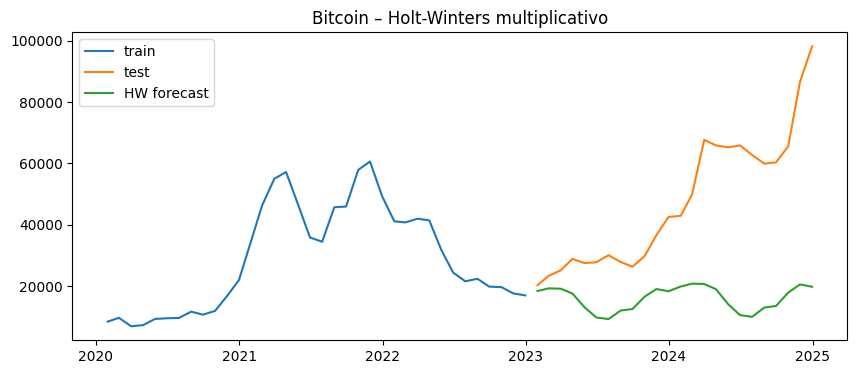

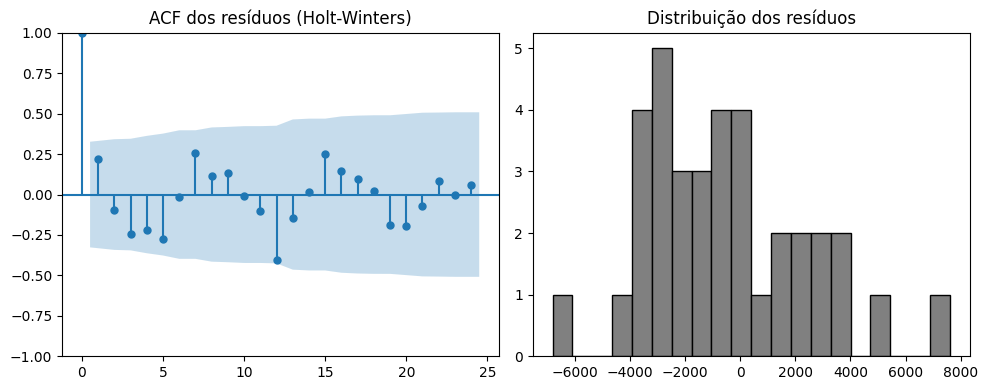

Exponente de Hurst (diário): 0.554
Entropia de Permutação (resíduos): 0.976
Desvio Padrão dos resíduos: 2989.441


In [ ]:
ts_btc = df_btc.set_index("date")["value"].asfreq("D").resample("ME").mean()
ts_btc = ts_btc.ffill()  # preenche eventuais lacunas

# Split: últimos 24 meses para teste
train_btc, test_btc = ts_btc.iloc[:-24], ts_btc.iloc[-24:]

hw_btc = ExponentialSmoothing(
    train_btc,
    trend="mul",
    seasonal="mul",
    seasonal_periods=12
).fit(optimized=True, use_brute=True)

pred_btc = hw_btc.forecast(len(test_btc))

mae_btc  = mean_absolute_error(test_btc, pred_btc)
mape_btc = mean_absolute_percentage_error(test_btc, pred_btc)

print(f"HW(ETS) Bitcoin  MAE={mae_btc:.2f}  MAPE={100*mape_btc:.2f}%")

plt.figure(figsize=(10,4))
plt.plot(train_btc.index, train_btc, label="train")
plt.plot(test_btc.index, test_btc, label="test")
plt.plot(pred_btc.index, pred_btc, label="HW forecast")
plt.legend()
plt.title("Bitcoin – Holt-Winters multiplicativo")
plt.show()

resid_btc = hw_btc.resid.dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sm.graphics.tsa.plot_acf(resid_btc, lags=24, ax=ax[0])
ax[0].set_title("ACF dos resíduos (Holt-Winters)")
ax[1].hist(resid_btc, bins=20, color='gray', edgecolor='black')
ax[1].set_title("Distribuição dos resíduos")
plt.tight_layout()
plt.show()

H_btc, _, _ = compute_Hc(df_btc["value"].dropna().values, simplified=True)

# Métricas complementares
pe_btc = ant.perm_entropy(resid_btc, normalize=True)
std_btc = resid_btc.std()

print(f"Exponente de Hurst (diário): {H_btc:.3f}")
print(f"Entropia de Permutação (resíduos): {pe_btc:.3f}")
print(f"Desvio Padrão dos resíduos: {std_btc:.3f}")


### Comparativo Final — Por que o modelo funcionou em *AirPassengers* e falhou em *Bitcoin*

Ao aplicar o modelo **Holt-Winters (ETS)** nas duas séries, fica evidente a diferença entre um processo **determinístico** (AirPassengers) e um **estocástico** (Bitcoin). Essa diferença estrutural explica o sucesso do modelo em um caso e seu fracasso no outro.

#### AirPassengers — Série Determinística e Estruturada

O modelo **capturou perfeitamente a estrutura da série**, pois ela possui:

1. **Tendência clara e suave** — crescimento consistente ao longo dos anos;
2. **Sazonalidade regular** — ciclos anuais repetitivos (picos e vales previsíveis);
3. **Ruído branco após a modelagem** — resíduos aleatórios, sem autocorrelação e com distribuição quase normal.

Os resultados quantitativos confirmam o bom ajuste:
- **MAPE:** 2.81% → excelente precisão preditiva;  
- **Hurst (resíduos):** 0.18 → comportamento anti-persistente, típico de ruído puro;  
- **Entropia:** 0.98 → série residual completamente desordenada (sem estrutura previsível).

**Conclusão:**  
A decomposição e o modelo ETS explicaram praticamente toda a estrutura determinística da série, restando apenas ruído branco.  
Isso caracteriza uma série **altamente previsível**, cujo comportamento é governado por componentes modeláveis (tendência + sazonalidade).

---

#### Bitcoin — Série Estocástica e Volátil

Já no caso da Bitcoin, o modelo **falhou estruturalmente** porque os pressupostos do Holt-Winters não são atendidos:

1. **Ausência de tendência estável** — longos períodos de alta e baixa sem padrão definido;  
2. **Sazonalidade inexistente** — flutuações irregulares e não periódicas;  
3. **Alta volatilidade e heterocedasticidade** — variação extrema dos valores ao longo do tempo.

Os resultados refletem essa imprevisibilidade:
- **MAPE:** 59.15% → o modelo não consegue acompanhar a dinâmica da série;  
- **Hurst (diário):** 0.55 → persistência moderada, indicando ruído correlacionado;  
- **Entropia:** 0.97 → série essencialmente aleatória, com pouca estrutura determinística;  
- **Desvio padrão dos resíduos:** muito elevado (~3.000), revelando forte dispersão e volatilidade residual.

A ACF dos resíduos ainda mostra autocorrelações significativas — prova de que o modelo **não conseguiu capturar dependências temporais**.

**Conclusão:**  
A Bitcoin é dominada por **ruído estruturado e choques externos**, impossíveis de representar por um modelo determinístico simples.  
Mesmo após a modelagem, restam padrões residuais e volatilidade não explicada, evidenciando uma **baixa previsibilidade intrínseca**.

Em séries como essa do Bitcoin, o valor preditivo tende a estar na **dinâmica de volatilidade, distribuição e probabilidade de movimentos**, não em adivinhar o preço absoluto; portanto, são séries que devem serem tratadas como um processo estocástico com informação exógena, necessitando de uma modelagem muito mais complexa a ser feita.

---

### Então por que metrificar e analisar a previsibilidade antes da modelagem é essencial

Avaliar métricas como o **exponente de Hurst**, a **entropia de permutação** e a **autocorrelação** antes de modelar fornece uma visão crítica sobre **o que esperar de cada série temporal**.  

Essas análises permitem:
- Identificar **se há estrutura determinística suficiente** para ser modelada;
- Evitar o uso de **modelos inadequados** (como ETS em séries puramente ruidosas);
- Antecipar **o limite teórico da previsibilidade** — ou seja, distinguir entre o que é previsível e o que é aleatório;
- Economizar tempo e esforço, ajustando a complexidade do modelo à natureza dos dados.

**Conclusão Geral:**  
> Metrificar a previsibilidade antes de modelar é uma etapa crucial da análise temporal.  
> Ela permite diferenciar fenômenos **estruturados e modeláveis** (como o tráfego aéreo) de fenômenos **caóticos e essencialmente aleatórios** (como o mercado de criptoativos).  
> Em suma, **entender a natureza da série é o primeiro passo para escolher o modelo certo e interpretar seus limites.**